In [36]:
# Importing the library
!pip install -q yfinance ta tensorflow scikit-learn matplotlib


In [37]:
# Imports and reproducibility
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("TF version:", tf.__version__)


TF version: 2.19.0


In [38]:
# CHANGE THESE as needed
TICKER = 'AAPL'
START = '2015-01-01'
END = '2025-10-31'
SEQ_LEN = 30             # lookback window
TEST_SIZE = 0.2          # fraction for test
EPOCHS = 20              # small by default
BATCH_SIZE = 32
THRESHOLD = 0.005        # 0.5% threshold for Buy/Hold/Sell


In [39]:
print("Downloading:", TICKER)
df = yf.download(TICKER, start=START, end=END, progress=False)

if df.empty:
    raise RuntimeError("No data downloaded. Check ticker & network.")

# Flatten MultiIndex columns to single level
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if col[0] != '' else col[1] for col in df.columns]

# Some tickers don't have Adj Close returned - handle gracefully
columns_needed = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
available_cols = [c for c in columns_needed if c in df.columns]

df = df[available_cols].copy()
df = df.reset_index(drop=True)

print("Columns after cleaning:", df.columns.tolist())
print("Rows:", len(df))
df.head()


Downloading: AAPL
Columns after cleaning: ['Open', 'High', 'Low', 'Close', 'Volume']
Rows: 2724


,Open,High,Low,Close,Volume
0,24.694235,24.705320,23.798600,24.237551,212818400
1,24.006992,24.086801,23.368521,23.554741,257142000
2,23.619031,23.816336,23.195599,23.556957,263188400
3,23.765347,23.987038,23.654501,23.887278,160423600
4,24.215376,24.862715,24.097878,24.805075,237458000


In [40]:
# Simple, safe indicator functions
def SMA(series, period):
    return series.rolling(window=period, min_periods=1).mean()

def RSI(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ma_up = up.rolling(window=period, min_periods=1).mean()
    ma_down = down.rolling(window=period, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

def MACD(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

def ATR(df_, period=14):
    high_low = df_['High'] - df_['Low']
    high_close = (df_['High'] - df_['Close'].shift()).abs()
    low_close = (df_['Low'] - df_['Close'].shift()).abs()
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window=period, min_periods=1).mean()

def OBV(df_):
    obv = [0]
    for i in range(1, len(df_)):
        if df_['Close'].iat[i] > df_['Close'].iat[i-1]:
            obv.append(obv[-1] + df_['Volume'].iat[i])
        elif df_['Close'].iat[i] < df_['Close'].iat[i-1]:
            obv.append(obv[-1] - df_['Volume'].iat[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=df_.index)

# Apply indicators
df['SMA_10'] = SMA(df['Close'], 10)
df['SMA_50'] = SMA(df['Close'], 50)
df['RSI'] = RSI(df['Close'], 14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = MACD(df['Close'])
df['ATR'] = ATR(df, 14)
df['OBV'] = OBV(df)
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

# Drop rows with NaNs from indicators
df = df.dropna().reset_index(drop=True)
print("Rows after indicators:", len(df))
df.tail(3)


Rows after indicators: 2723


,Open,High,Low,Close,Volume,SMA_10,SMA_50,RSI,MACD,MACD_signal,MACD_hist,ATR,OBV,Log_Ret
2720,268.729471,269.628624,267.890289,268.739471,41534800,259.023897,245.410498,61.176941,5.462752,4.512618,0.950133,5.645246,7096909800,0.000707
2721,269.019206,271.147148,266.851294,269.438812,51086700,261.057925,246.192540,67.163566,5.820925,4.774280,1.046645,5.601003,7147996500,0.002599
2722,271.726571,273.874513,268.219991,271.137146,69886500,263.450604,247.099461,83.891081,6.170689,5.053562,1.117127,5.121468,7217883000,0.006283


In [41]:
FEATURE_COLS = ['Open','High','Low','Close','Volume','SMA_10','SMA_50','RSI','MACD','MACD_signal','MACD_hist','ATR','OBV','Log_Ret']
# --- Feature Scaling ---
features = df[FEATURE_COLS].copy()
feature_scaler = MinMaxScaler()
features_scaled = pd.DataFrame(feature_scaler.fit_transform(features), columns=features.columns)

# scaler for Close separately (so we can invert predictions)
close_scaler = MinMaxScaler()
close_scaled = close_scaler.fit_transform(df[['Close']])

# --- Sequence creation with reproducibility ---
def create_sequences(features_df, close_arr, seq_len):
    X, y = [], []
    n = len(features_df)
    for i in range(0, n - seq_len):
        X.append(features_df.iloc[i:i+seq_len].values)
        y.append(close_arr[i+seq_len][0])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

SEQ_LEN = 60  # example sequence length
X, y = create_sequences(features_scaled, close_scaled, SEQ_LEN)
print("X shape:", X.shape, "y shape:", y.shape)

# --- Train/test split (fixed indices for reproducibility) ---
TEST_SIZE = 0.2
split_idx = int((1 - TEST_SIZE) * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])


X shape: (2663, 60, 14) y shape: (2663,)
Train samples: 2130 Test samples: 533


In [42]:
# Lightweight attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],1), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, inputs):
        u_it = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        ait = tf.nn.softmax(tf.tensordot(u_it, self.u, axes=1), axis=1)
        ait = tf.squeeze(ait, -1)
        weighted = tf.reduce_sum(inputs * tf.expand_dims(ait, -1), axis=1)
        return weighted

# Model builders (kept modest for Colab)
def build_lstm_attention(input_shape):
    inp = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inp)
    x = Dropout(0.2)(x)
    att = AttentionLayer()(x)
    out = Dense(1)(att)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_lstm_gru(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_lstm_cnn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_bilstm_gru(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
models = {
    'lstm_attention': build_lstm_attention(input_shape),
    'lstm_gru': build_lstm_gru(input_shape),
    'lstm_cnn': build_lstm_cnn(input_shape),
    'bilstm_gru': build_bilstm_gru(input_shape)
}
print("Models built. Ready to train.")


Models built. Ready to train.


In [43]:
EPOCHS = EPOCHS
BATCH_SIZE = BATCH_SIZE

results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    ckpt = f"{name}_best.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0),
        ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
    ]
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=callbacks, verbose=1)
    # Predict - invert scaled close to original price
    preds_scaled = model.predict(X_test).ravel()
    preds_orig = close_scaler.inverse_transform(preds_scaled.reshape(-1,1)).ravel()
    y_test_orig = close_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
    mse = mean_squared_error(y_test_orig, preds_orig)
    mae = mean_absolute_error(y_test_orig, preds_orig)
    r2 = r2_score(y_test_orig, preds_orig)
    results[name] = {'mse': float(mse), 'mae': float(mae), 'r2': float(r2)}
    model.save(f"{name}_final.h5")
    print(f"{name} -> MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

print("\nAll models trained. Summary:")
for k,v in results.items():
    print(k, v)



Training lstm_attention ...
Epoch 1/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0091 - mae: 0.0668

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0089 - mae: 0.0659 - val_loss: 0.0026 - val_mae: 0.0436 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 8.6158e-04 - mae: 0.0208

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.6159e-04 - mae: 0.0208 - val_loss: 0.0018 - val_mae: 0.0362 - learning_rate: 0.0010
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 7.5405e-04 - mae: 0.0197 - val_loss: 0.0023 - val_mae: 0.0413 - learning_rate: 0.0010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.8696e-04 - mae: 0.0203

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 7.8619e-04 - mae: 0.0203 - val_loss: 0.0014 - val_mae: 0.0308 - learning_rate: 0.0010
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.1376e-04 - mae: 0.0177 - val_loss: 0.0014 - val_mae: 0.0285 - learning_rate: 0.0010
Epoch 6/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.8480e-04 - mae: 0.0172

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.8482e-04 - mae: 0.0172 - val_loss: 0.0014 - val_mae: 0.0302 - learning_rate: 0.0010
Epoch 7/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.0677e-04 - mae: 0.0159

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5.0653e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0279 - learning_rate: 0.0010
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 4.7569e-04 - mae: 0.0156 - val_loss: 0.0015 - val_mae: 0.0309 - learning_rate: 5.0000e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.2803e-04 - mae: 0.0146 - val_loss: 0.0014 - val_mae: 0.0309 - learning_rate: 5.0000e-04
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.1035e-04 - mae: 0.0141 - val_loss: 0.0015 - val_mae: 0.0316 - learning_rate: 5.0000e-04
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.1293e-04 - mae: 0.0143 - val_loss: 0.0015 - val_mae: 0.0316 - learning_rate: 2.5000e-04
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.7230e-04 - mae: 0.0136 - val_loss: 0.0014 - val_mae: 0.0310 - learning_rate: 2.5000e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


lstm_attention -> MAE: 13.6833, MSE: 308.5495, R2: 0.5388

Training lstm_gru ...
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0362 - mae: 0.1227

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0358 - mae: 0.1218 - val_loss: 0.0020 - val_mae: 0.0391 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0014 - mae: 0.0293

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0014 - mae: 0.0293 - val_loss: 8.9148e-04 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 8.7802e-04 - mae: 0.0231

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 8.7827e-04 - mae: 0.0231 - val_loss: 6.7878e-04 - val_mae: 0.0219 - learning_rate: 0.0010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 6.8040e-04 - mae: 0.0197

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 6.7984e-04 - mae: 0.0197 - val_loss: 4.3976e-04 - val_mae: 0.0161 - learning_rate: 0.0010
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 5.2240e-04 - mae: 0.0171 - val_loss: 4.7339e-04 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 5.2881e-04 - mae: 0.0169 - val_loss: 7.6277e-04 - val_mae: 0.0238 - learning_rate: 0.0010
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 5.1351e-04 - mae: 0.0171 - val_loss: 5.8155e-04 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.4555e-04 - mae: 0.0140

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.4567e-04 - mae: 0.0140 - val_loss: 3.5253e-04 - val_mae: 0.0151 - learning_rate: 5.0000e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.9521e-04 - mae: 0.0126

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 2.9558e-04 - mae: 0.0126 - val_loss: 3.2411e-04 - val_mae: 0.0144 - learning_rate: 5.0000e-04
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.2579e-04 - mae: 0.0133

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 3.2602e-04 - mae: 0.0133 - val_loss: 3.0375e-04 - val_mae: 0.0132 - learning_rate: 5.0000e-04
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.6351e-04 - mae: 0.0122 - val_loss: 3.2985e-04 - val_mae: 0.0148 - learning_rate: 5.0000e-04
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 2.8591e-04 - mae: 0.0123 - val_loss: 4.1393e-04 - val_mae: 0.0171 - learning_rate: 5.0000e-04
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 2.4220e-04 - mae: 0.0111 - val_loss: 3.3834e-04 - val_mae: 0.0150 - learning_rate: 2.5000e-04
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 2.3296e-04 - mae: 0.0110 - val_loss: 3.0666e-04 - val_mae: 0.0141 - learning_rate: 2.5000e-04
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 2.5955e-04 - mae: 0.0116 - val_loss: 4.5947e-04 - val_mae: 0.0180 - learning_rate: 2.5000e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


lstm_gru -> MAE: 9.5270, MSE: 145.7457, R2: 0.7821

Training lstm_cnn ...
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0209 - mae: 0.0961

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0207 - mae: 0.0953 - val_loss: 0.0013 - val_mae: 0.0300 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.3298e-04 - mae: 0.0156

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.3249e-04 - mae: 0.0156 - val_loss: 0.0012 - val_mae: 0.0291 - learning_rate: 0.0010
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0275e-04 - mae: 0.0129

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.0280e-04 - mae: 0.0129 - val_loss: 7.7234e-04 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.3315e-04 - mae: 0.0110

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.3323e-04 - mae: 0.0110 - val_loss: 6.3779e-04 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 5/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9802e-04 - mae: 0.0097

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9840e-04 - mae: 0.0097 - val_loss: 5.9022e-04 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8252e-04 - mae: 0.0092

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.8267e-04 - mae: 0.0092 - val_loss: 5.7367e-04 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7256e-04 - mae: 0.0088

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7269e-04 - mae: 0.0088 - val_loss: 5.4393e-04 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7201e-04 - mae: 0.0089 - val_loss: 6.8729e-04 - val_mae: 0.0223 - learning_rate: 5.0000e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9202e-04 - mae: 0.0099 - val_loss: 6.7038e-04 - val_mae: 0.0220 - learning_rate: 5.0000e-04
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8868e-04 - mae: 0.0099 - val_loss: 6.5312e-04 - val_mae: 0.0217 - learning_rate: 5.0000e-04
Epoch 11/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5736e-04 - mae: 0.0085

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5743e-04 - mae: 0.0085 - val_loss: 5.2531e-04 - val_mae: 0.0189 - learning_rate: 2.5000e-04
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4250e-04 - mae: 0.0079

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4266e-04 - mae: 0.0079 - val_loss: 5.0839e-04 - val_mae: 0.0185 - learning_rate: 2.5000e-04
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4136e-04 - mae: 0.0079

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4151e-04 - mae: 0.0079 - val_loss: 4.8698e-04 - val_mae: 0.0181 - learning_rate: 2.5000e-04
Epoch 14/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3976e-04 - mae: 0.0078

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.4005e-04 - mae: 0.0078 - val_loss: 4.6802e-04 - val_mae: 0.0176 - learning_rate: 2.5000e-04
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3549e-04 - mae: 0.0075

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3567e-04 - mae: 0.0075 - val_loss: 4.1414e-04 - val_mae: 0.0161 - learning_rate: 1.2500e-04
Epoch 16/20
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2917e-04 - mae: 0.0073

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2986e-04 - mae: 0.0073 - val_loss: 4.0833e-04 - val_mae: 0.0159 - learning_rate: 1.2500e-04
Epoch 17/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2823e-04 - mae: 0.0073

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.2869e-04 - mae: 0.0073 - val_loss: 4.0433e-04 - val_mae: 0.0158 - learning_rate: 1.2500e-04
Epoch 18/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2756e-04 - mae: 0.0072

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2778e-04 - mae: 0.0073 - val_loss: 4.0138e-04 - val_mae: 0.0158 - learning_rate: 1.2500e-04
Epoch 19/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2448e-04 - mae: 0.0071 - val_loss: 4.0604e-04 - val_mae: 0.0160 - learning_rate: 6.2500e-05
Epoch 20/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2551e-04 - mae: 0.0071 - val_loss: 4.0288e-04 - val_mae: 0.0159 - learning_rate: 6.2500e-05
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


lstm_cnn -> MAE: 12.8773, MSE: 235.8941, R2: 0.6474

Training bilstm_gru ...
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0609 - mae: 0.1627

60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.0602 - mae: 0.1615 - val_loss: 0.0016 - val_mae: 0.0360 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0015 - mae: 0.0302

60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0015 - mae: 0.0302 - val_loss: 3.8461e-04 - val_mae: 0.0166 - learning_rate: 0.0010
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0010 - mae: 0.0249

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0010 - mae: 0.0249 - val_loss: 2.8902e-04 - val_mae: 0.0142 - learning_rate: 0.0010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 7.0725e-04 - mae: 0.0205

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 7.0669e-04 - mae: 0.0205 - val_loss: 2.6794e-04 - val_mae: 0.0138 - learning_rate: 0.0010
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 5.6320e-04 - mae: 0.0185

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 5.6363e-04 - mae: 0.0185 - val_loss: 2.6523e-04 - val_mae: 0.0138 - learning_rate: 0.0010
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 4.3834e-04 - mae: 0.0162

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 4.3841e-04 - mae: 0.0162 - val_loss: 1.8435e-04 - val_mae: 0.0102 - learning_rate: 0.0010
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 3.5230e-04 - mae: 0.0145 - val_loss: 3.0778e-04 - val_mae: 0.0150 - learning_rate: 0.0010
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 3.5687e-04 - mae: 0.0145

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 3.5678e-04 - mae: 0.0145 - val_loss: 1.7896e-04 - val_mae: 0.0101 - learning_rate: 5.0000e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.1856e-04 - mae: 0.0133

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 3.1866e-04 - mae: 0.0133 - val_loss: 1.6582e-04 - val_mae: 0.0101 - learning_rate: 5.0000e-04
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 3.0004e-04 - mae: 0.0133 - val_loss: 1.9357e-04 - val_mae: 0.0113 - learning_rate: 5.0000e-04
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 2.7501e-04 - mae: 0.0127 - val_loss: 1.8666e-04 - val_mae: 0.0110 - learning_rate: 5.0000e-04
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 2.8474e-04 - mae: 0.0129 - val_loss: 1.7088e-04 - val_mae: 0.0101 - learning_rate: 5.0000e-04
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 2.9190e-04 - mae: 0.0128 - val_loss: 1.7813e-04 - val_mae: 0.0107 - learning_rate: 2.5000e-04
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 2.5664e-04 - mae: 0.0120 - val_loss: 1.8088e-04 - val_mae: 0.0108 - learning_rate: 2.5000e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


bilstm_gru -> MAE: 7.0387, MSE: 81.1707, R2: 0.8787

All models trained. Summary:
lstm_attention {'mse': 308.5494689941406, 'mae': 13.683328628540039, 'r2': 0.538799524307251}
lstm_gru {'mse': 145.74571228027344, 'mae': 9.526955604553223, 'r2': 0.7821484804153442}
lstm_cnn {'mse': 235.89405822753906, 'mae': 12.877326965332031, 'r2': 0.6474003791809082}
bilstm_gru {'mse': 81.17068481445312, 'mae': 7.038697719573975, 'r2': 0.8786711692810059}


In [44]:
# Pick best by MSE
best_name = min(results, key=lambda k: results[k]['mse'])
print("Best model:", best_name)
best_model = models[best_name]

preds_scaled = best_model.predict(X_test).ravel()
preds_orig = close_scaler.inverse_transform(preds_scaled.reshape(-1,1)).ravel()
y_test_orig = close_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

# Build aligned today_close for signals
test_sequence_start_indices = np.arange(split_idx, split_idx + len(X_test))
today_close_vals = []
for seq_start in test_sequence_start_indices:
    idx = int(seq_start + SEQ_LEN - 1)
    today_close_vals.append(df['Close'].iat[idx])
today_close_vals = np.array(today_close_vals)

predicted_returns = (preds_orig - today_close_vals) / (today_close_vals + 1e-9)

def returns_to_signal(returns, thr=THRESHOLD):
    signals = []
    for r in returns:
        if r > thr:
            signals.append(2)  # Buy
        elif r < -thr:
            signals.append(0)  # Sell
        else:
            signals.append(1)  # Hold
    return np.array(signals)

signals = returns_to_signal(predicted_returns, THRESHOLD)
(unique, counts) = np.unique(signals, return_counts=True)
print("Signal distribution (0=Sell,1=Hold,2=Buy):", dict(zip(unique, counts)))


Best model: bilstm_gru
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Signal distribution (0=Sell,1=Hold,2=Buy): {np.int64(0): np.int64(434), np.int64(1): np.int64(52), np.int64(2): np.int64(47)}


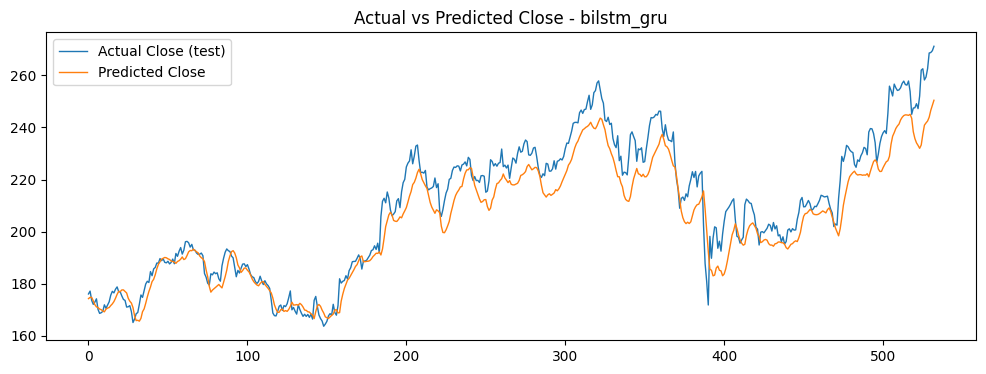

Saved: AAPL_pred_signals_bilstm_gru.csv


In [45]:
# Plot actual vs predicted for test
plt.figure(figsize=(12,4))
plt.plot(y_test_orig, label='Actual Close (test)', linewidth=1)
plt.plot(preds_orig, label='Predicted Close', linewidth=1)
plt.title(f"Actual vs Predicted Close - {best_name}")
plt.legend()
plt.show()

# Save CSV of results (to Colab runtime; move to Drive if mounted)
out_df = pd.DataFrame({
    'predicted_close': preds_orig,
    'actual_close': y_test_orig,
    'today_close': today_close_vals,
    'predicted_return': predicted_returns,
    'signal': signals
})
csv_name = f"{TICKER}_pred_signals_{best_name}.csv"
out_df.to_csv(csv_name, index=False)
print("Saved:", csv_name)

In [46]:
# Correct Adjusted R^2 calculation
def adjusted_r2(y_true, y_pred, p):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / max(n - p - 1, 1)

# Number of actual predictors (feature columns)
p = len(FEATURE_COLS)

adj_r2 = adjusted_r2(y_test_orig, preds_orig, p)

print(f"\n🔹 Final Evaluation for Best Model: {best_name}")
print(f"MAE: {results[best_name]['mae']:.4f}")
print(f"MSE: {results[best_name]['mse']:.4f}")
print(f"R² : {results[best_name]['r2']:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")



🔹 Final Evaluation for Best Model: bilstm_gru
MAE: 7.0387
MSE: 81.1707
R² : 0.8787
Adjusted R²: 0.8754


Detected columns: actual_close today_close signal


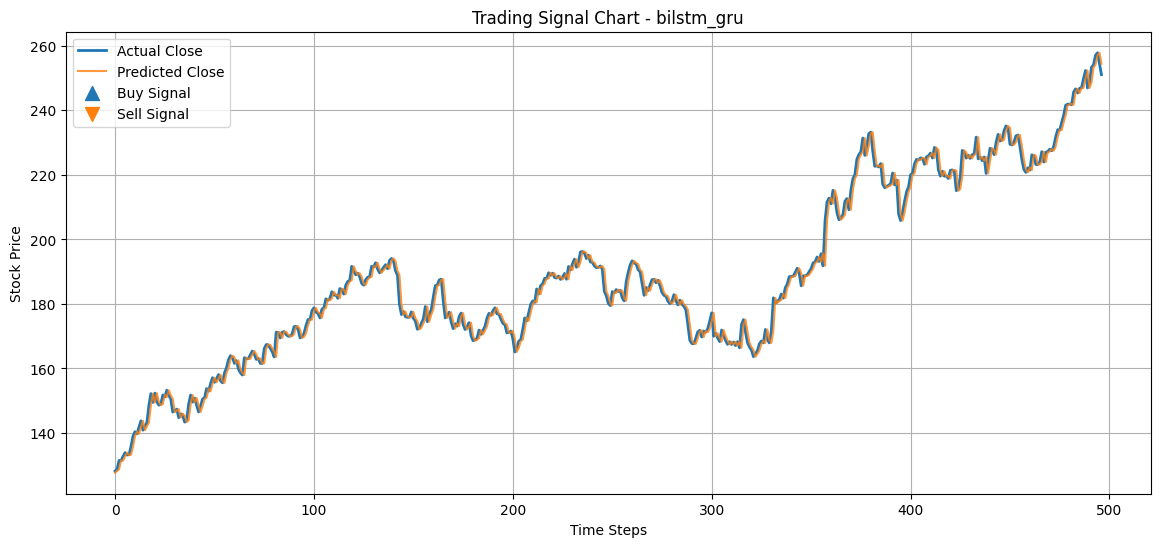

In [47]:
# Automatically detect correct column names (case-insensitive)
cols = {c.lower(): c for c in signals_df.columns}

actual_col = cols.get('actual close') or cols.get('actual') or list(signals_df.columns)[1]
pred_col   = cols.get('predicted close') or cols.get('predicted') or list(signals_df.columns)[2]
signal_col = cols.get('signal')

print("Detected columns:", actual_col, pred_col, signal_col)

plt.figure(figsize=(14,6))
plt.plot(signals_df[actual_col], label='Actual Close', linewidth=2)
plt.plot(signals_df[pred_col], label='Predicted Close', alpha=0.8)

# Plot Buy & Sell points
buy_points  = signals_df[signals_df[signal_col] == 'Buy']
sell_points = signals_df[signals_df[signal_col] == 'Sell']

plt.scatter(buy_points.index, buy_points[actual_col], marker='^', s=100, label='Buy Signal')
plt.scatter(sell_points.index, sell_points[actual_col], marker='v', s=100, label='Sell Signal')

plt.title(f"Trading Signal Chart - {best_name}")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# Performance Comparison Table
comparison_df = pd.DataFrame(results).T
comparison_df.index.name = "Model"
comparison_df = comparison_df.reset_index()

# Format better
comparison_df['mse'] = comparison_df['mse'].round(4)
comparison_df['mae'] = comparison_df['mae'].round(4)
comparison_df['r2']  = comparison_df['r2'].round(4)

print("📊 Model Performance Comparison:")
comparison_df


📊 Model Performance Comparison:


,Model,mse,mae,r2
0,lstm_attention,308.5495,13.6833,0.5388
1,lstm_gru,145.7457,9.5270,0.7821
2,lstm_cnn,235.8941,12.8773,0.6474
3,bilstm_gru,81.1707,7.0387,0.8787
